In [1]:
import mdtraj as md
import nglview
import numpy as np
import matplotlib.pyplot as plt
import scipy
import itertools
from itertools import combinations
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
from sklearn.decomposition import PCA

In [2]:
# distances: nm, time: ps, angle: degree
topoFile = r'D:\MD\ASAP-sim\ASAP3b\A-GFP\system_dabbled.psf'
trajFile = r'D:\MD\ASAP-sim\ASAP3b\A-GFP\run_1.nc'
traj = md.load(trajFile, top=topoFile)
topo = traj.topology

print(traj.n_atoms)
#traj = traj.atom_slice(topo.select("protein"))
#print(traj.n_atoms)
nglview.NGLWidget(nglview.MDTrajTrajectory(traj))

92627


NGLWidget(max_frame=205)

- residues of interest
    - F413 PHE, 365 in PyMol
    - Q414 GLN, 366 in PyMol

In [3]:
def getRes(topo, seq):
    return [r for r in topo.residues if (r.is_protein and r.resSeq == seq)][0]

print(getRes(topo, 365))
print(getRes(topo, 366))

PHE365
GLN366


In [4]:
a1 = topo.select("protein and resname PHE and resSeq 365")

In [5]:
a2 = [atom.index for atom in getRes(topo, 365).atoms]

In [6]:
print(a1==a2)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


- compute all pairwise RMSDs between conformations
- transform RMSDs into similarity scores: $s_{ij} = e^{-\beta d_{ij}/d_\text{scale}}$, where $d_\text{scale}$ is standard deviation of $d$, to make the computation scale invariant
- centroid := $\arg\max_i \sum_j s_{ij}$

In [7]:
def getRMSDs(traj):
    topo = traj.topology
    nf = traj.n_frames
    atomIdxs = topo.select("protein and type != H")
    dists = np.empty([nf, nf])
    for i in range(nf):
        dists[i] = md.rmsd(target=traj, reference=traj, frame=i, atom_indices=atomIdxs)
    return dists
    
def findCentroid(traj):
    dists = getRMSDs(traj)
    beta = 1
    idx = np.exp(-beta*dists / dists.std()).sum(axis=1).argmax()
    centroid = traj[idx]
    return idx, centroid
    
idx, centroid = findCentroid(traj)
print(idx, centroid)

92 <mdtraj.Trajectory with 1 frames, 92627 atoms, 20533 residues, and unitcells>


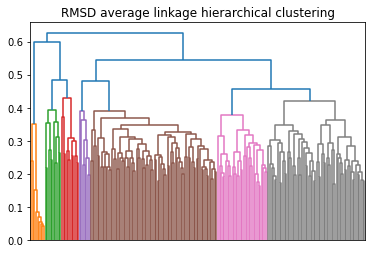

In [8]:
def clustering(traj):
    dists = getRMSDs(traj)
    #assert np.all(dists - dists.T < 1e-6)
    reduced_dists = squareform(dists, checks=False)
    lkg = linkage(reduced_dists, method='average')
    plt.title('RMSD average linkage hierarchical clustering')
    _ = dendrogram(lkg, no_labels=True, count_sort='descendent')

clustering(traj)

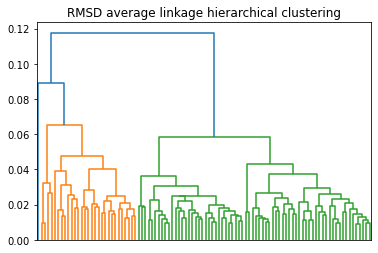

In [9]:
traj2 = md.load('./ala2.h5')
clustering(traj2)

*PHE365-N -- LEU361-O
SER369-N -- *PHE365-O
SER369-OG -- *PHE365-O


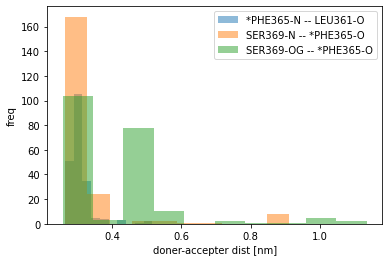

ARG363-NH1 -- *GLN366-OE1
*GLN366-N -- ILE362-O
SER369-N -- *GLN366-O
GLN370-N -- *GLN366-O
GLN370-NE2 -- *GLN366-O


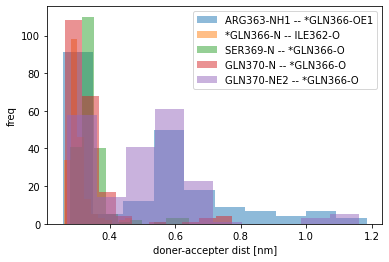

In [10]:
def findHbonds(traj, seqs):
    hbondsAll = md.baker_hubbard(traj, periodic=False)
    topo = traj.topology
    def inSeqs(res): return res.is_protein and res.resSeq in seqs
    def filt(hbond):
        r1, r2 = topo.atom(hbond[0]).residue, topo.atom(hbond[2]).residue
        return inSeqs(r1) or inSeqs(r2)
    hbondsIdxs = [i for i, hbond in enumerate(hbondsAll) if filt(hbond)]
    hbonds = hbondsAll[hbondsIdxs]
    def label(hbond):
        a1, a2 = topo.atom(hbond[0]), topo.atom(hbond[2])
        def mark(a): return '*' if inSeqs(a.residue) else ''
        return '%s%s -- %s%s' % (mark(a1), a1, mark(a2), a2)
    for h in hbonds:
        print(label(h))
    da_dists = md.compute_distances(traj, hbonds[:, [0,2]], periodic=False)
    for i, hbond in enumerate(hbonds):
        plt.hist(da_dists[:, i], label=label(hbond), alpha=0.5)
    plt.legend()
    plt.ylabel('freq')
    plt.xlabel('doner-accepter dist [nm]')
    plt.show()

findHbonds(traj, [365])
findHbonds(traj, [366])

number of native contacts 4700


<ipython-input-11-be8d5a763849>:16: RuntimeWarning: overflow encountered in exp
  frac = np.mean(1/(1+np.exp(BETA*(r-LAMBDA*r0))), axis=1)


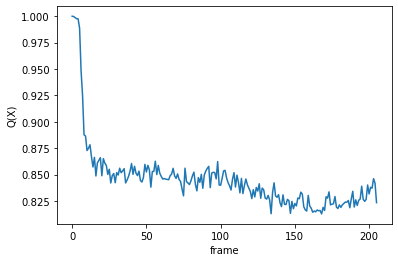

In [11]:
def nativeContacts(traj, nativeTraj):
    BETA = 50 # 1/nm
    LAMBDA = 1.8
    NATIVE_CUTOFF = 0.45 # nm
    heavyIdxs = nativeTraj.topology.select_atom_indices('heavy')
    def filt(traj, i, j):
        def res(n): return traj.topology.atom(n).residue.index
        return abs(res(i)-res(j)) > 3
    heavyPairs = np.array([(i,j) for (i,j) in combinations(heavyIdxs, 2) \
                           if filt(nativeTraj, i, j)])
    dists = md.compute_distances(nativeTraj[0], heavyPairs)[0]
    contacts = heavyPairs[dists < NATIVE_CUTOFF]
    print("number of native contacts", len(contacts))
    r  = md.compute_distances(traj, contacts)
    r0 = md.compute_distances(nativeTraj[0], contacts)
    frac = np.mean(1/(1+np.exp(BETA*(r-LAMBDA*r0))), axis=1)
    plt.plot(frac)
    plt.xlabel('frame')
    plt.ylabel('Q(X)')
    plt.show()
    return frac

frac = nativeContacts(traj, traj[0])


92627
6014
22
22


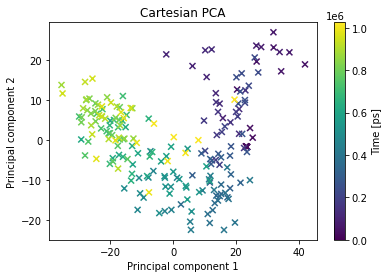

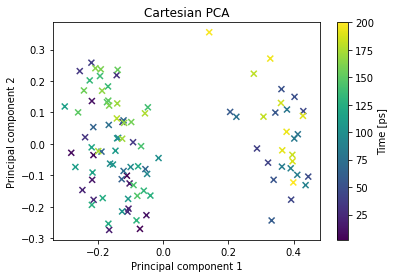

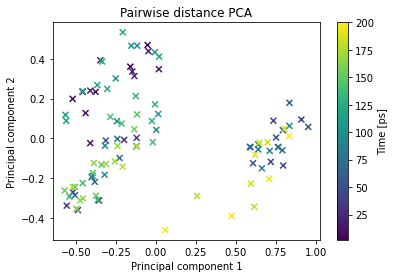

In [13]:
def pltPCA(reduced, time, title):
    plt.figure()
    plt.scatter(reduced[:,0], reduced[:,1], marker='x', c=time)
    plt.xlabel('Principal component 1')
    plt.ylabel('Principal component 2')
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label('Time [ps]')

def xyzPCA(traj):
    print(traj.n_atoms)
    traj = traj.atom_slice(traj.topology.select("protein"))
    print(traj.n_atoms)
    traj.superpose(traj, 0)
    xyz = traj.xyz.reshape(traj.n_frames, traj.n_atoms*3)
    pltPCA(PCA(2).fit_transform(xyz), traj.time, 'Cartesian PCA')

def pairDistPCA(traj):
    traj = traj.atom_slice(traj.topology.select("protein"))
    atomPairs = list(combinations(range(traj.n_atoms), 2))
    pairDists = md.geometry.compute_distances(traj, atomPairs) 
    pltPCA(PCA(2).fit_transform(pairDists), traj.time, 'Pairwise distance PCA')

xyzPCA(traj)
#pairDistPCA(traj)
xyzPCA(traj2)
pairDistPCA(traj2)

In [ ]:
def ramachandran():
    

In [ ]:
"""
psf = CharmmPsfFile(psf)
params = CharmmParameterSet('charmm22.rtf', 'charmm22.par')
system = psf.createSystem(params, nonbondedMethod=NoCutoff,
        nonbondedCutoff=1*nanometer, constraints=HBonds)
integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)
simulation = Simulation(psf.topology, system, integrator)
"""
"""
forceField = ForceField('charmm36.xml', 'charmm36/water.xml')
system = forceField.createSystem(
    traj.topology.to_openmm(), 
    #nonbondedMethod=PME,
    #nonbondedCutoff=1*nanometer, 
    #constraints=HBonds
)
integrator = LangevinMiddleIntegrator(
    300*kelvin, 1/picosecond, 0.004*picoseconds
)
simulation = Simulation(
    traj.topology, system, integrator
)
"""